In [468]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

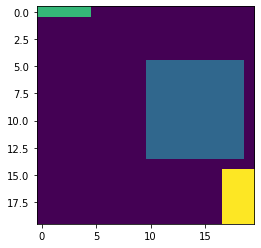

In [476]:
patches_size = 10
map_size = 20
n_patches = 3

race_map = np.zeros((map_size+patches_size, map_size+patches_size))

for i in range(n_patches):
    size = int(np.random.random()*patches_size)
    center = (int(np.random.random()*map_size),int(np.random.random()*map_size))
    race_map[center[0]:center[0]+size,center[1]:center[1]+size]=1
race_map = race_map[:-patches_size,:-patches_size]
#race_map[:5,-5:] =1

#Lines
race_map[0,:5] = 2
race_map[-5:,-3:] = 3


plt.imshow(race_map)

### Enviroment

In [477]:
set_of_actions = [
    [-1,-1],
    [-1, 0],
    [-1, 1],
    [ 0,-1],
    [ 0, 0],
    [ 0, 1],
    [ 1,-1],
    [ 1, 0],
    [ 1, 1],
]

def simulate_episode(policy):
    def step(state, action):
        
        next_state =  state.copy()
        next_state[0] += state[2]
        next_state[1] += state[3]
        next_state[2] += action[0]
        next_state[3] += action[1]
        
        
        next_state[2] = next_state[2] if next_state[2] > -1 else 0
        next_state[3] = next_state[3] if next_state[3] > -1 else 0
        
        next_state[2] = next_state[2] if next_state[2] <= 4 else 4
        next_state[3] = next_state[3] if next_state[3] <= 4 else 4
        
        if next_state[0]<0 or next_state[0]>=map_size or  next_state[1]<0 or next_state[1]>=map_size :
            
            next_state = state.copy()
            
            next_state[2] = 0
            next_state[3] = 0
            
            return (next_state,-3)
            
        if race_map[next_state[0],next_state[1]] == 1:
            next_state = state.copy()
            next_state[2] = 0
            next_state[3] = 0
            
            return (next_state,-3)
            
        # End case
        if ((np.argwhere(race_map==3)[:,0] == next_state[0]) & (np.argwhere(race_map==3)[:,1] == next_state[1])).any(): 
            
            return (next_state,30)
        
        return (next_state,-1)
        
    start_point = np.argwhere(race_map==2)[np.random.choice(len(np.argwhere(race_map==2)))]
    state = [ 
        start_point[0],
        start_point[1],
        0, 0
    ]
    
    states = [state]
    actions = []
    rewards = []
    
    while True:
        
        action = set_of_actions[np.random.choice(9,p=policy[state[0],state[1],state[2],state[3]])]
        action = set_of_actions[8] if len(states) == 1 else action
        state,reward = step(state, action)

        states.append(state)
        actions.append(action)
        rewards.append(reward)
        
        if ((np.argwhere(race_map==3)[:,0] == state[0]) & (np.argwhere(race_map==3)[:,1] == state[1])).any(): 
            return (states,actions,rewards)



### Train

In [478]:
Q = np.random.rand(map_size,map_size,6,6,9) + 20
C = np.zeros((map_size,map_size,6,6,9))

policy_pi = np.argmax(Q,axis=-1)


In [480]:
time_to_end = []

In [482]:
episodes = 50000
gamma = .99

for episode_idx in tqdm(range(episodes)):
    
    # Prepare soft policy
    rsh_pi = policy_pi.reshape((map_size**2 * 6**2))
    policy_b = np.zeros((rsh_pi.size, rsh_pi.max()+1))
    policy_b[:,:] = .4/8
    policy_b[np.arange(rsh_pi.size),rsh_pi] = .6
    policy_b = policy_b.reshape(Q.shape)
    
    # Generate episode
    states,actions,rewards = simulate_episode(policy_b)
    time_to_end.append(len(rewards))
    G = 0
    W = 1
    
    for i in range(len(states)-1):
        s,a,r = states[-(i+2)], actions[-(i+1)], rewards[-(i+1)]
        a_idx = (a[0]+1)*3+(a[1]+1)
        G = r + gamma * G
        C[s[0],s[1],s[2],s[3],a_idx] += W
        
        Q[s[0],s[1],s[2],s[3],a_idx] += W*(G - Q[s[0],s[1],s[2],s[3],a_idx])/C[s[0],s[1],s[2],s[3],a_idx]
        policy_pi = np.argmax(Q,axis=-1)
        if policy_pi[s[0],s[1],s[2],s[3]] != a_idx or policy_b[s[0],s[1],s[2],s[3],a_idx] == 0:
            break
        
        W /= policy_b[s[0],s[1],s[2],s[3],a_idx]

100%|██████████| 50000/50000 [04:55<00:00, 169.20it/s]


### Results

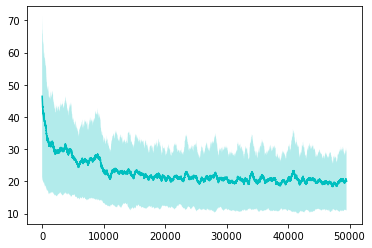

In [519]:
mean = []
ran = []
window_size = 500
for i in range(len(time_to_end)-window_size):
    mean.append(np.mean(time_to_end[i:i+window_size]))
    ran.append(np.mean(np.abs(time_to_end[i:i+window_size]-mean[-1])))

plt.fill_between(np.arange(len(mean)),np.array(mean)+np.array(ran), np.array(mean)-np.array(ran),alpha=0.3,facecolor="c")
plt.plot(mean,c="c")

In [487]:
rsh_pi = policy_pi.reshape((map_size**2 * 6**2))
policy_b = np.zeros((rsh_pi.size, rsh_pi.max()+1))
policy_b[:,:] = .1/8
policy_b[np.arange(rsh_pi.size),rsh_pi] = .9
policy_b = policy_b.reshape(Q.shape)

In [488]:
states,actions,rewards = simulate_episode(policy_b)

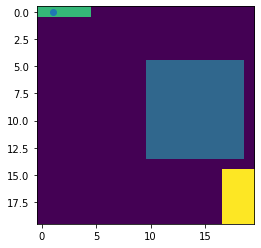

state:[0, 1, 0, 0]
actions:[1, 1]
 rewards:-1


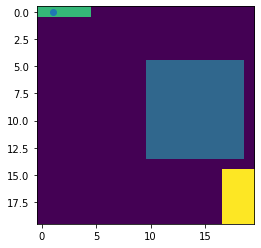

state:[0, 1, 1, 1]
actions:[1, 0]
 rewards:-1


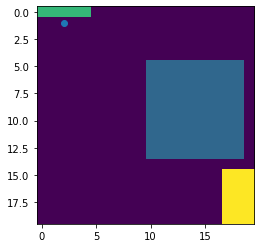

state:[1, 2, 2, 1]
actions:[1, 0]
 rewards:-1


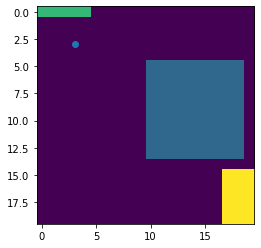

state:[3, 3, 3, 1]
actions:[0, 1]
 rewards:-1


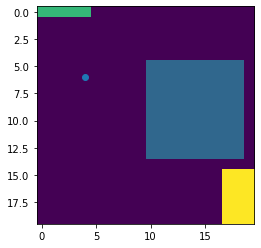

state:[6, 4, 3, 2]
actions:[-1, 1]
 rewards:-1


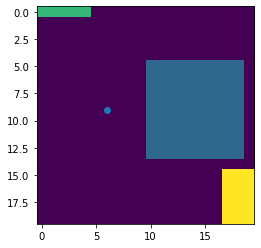

state:[9, 6, 2, 3]
actions:[1, 1]
 rewards:-1


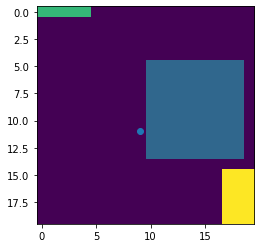

state:[11, 9, 3, 4]
actions:[0, 1]
 rewards:-1


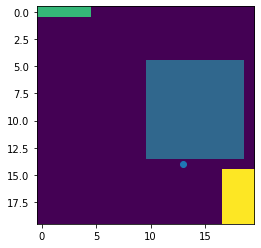

state:[14, 13, 3, 4]
actions:[-1, -1]
 rewards:30


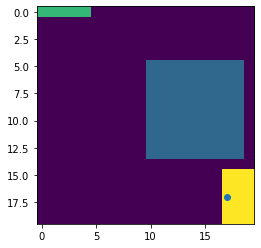

In [490]:
for i,j,k in zip(states,rewards,actions):
    plt.imshow(race_map)
    plt.scatter(i[1],i[0])
    plt.show()
    print(f"state:{i}")
    print(f"actions:{k}\n rewards:{j}")


plt.imshow(race_map)
plt.scatter(states[-1][1],states[-1][0])
plt.show()